In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from helpr.physics.api import CrackEvolutionAnalysis
from helpr.utilities.unit_conversion import convert_psi_to_mpa, convert_in_to_m
from helpr.utilities.plots import plot_cycle_life_cdfs, plot_cycle_life_pdfs, plot_cycle_life_criteria_scatter, plot_pipe_life_ensemble
from probabilistic.capabilities.uncertainty_definitions import UniformDistribution, NormalDistribution, DeterministicCharacterization

## **Inspection Mitigation Analysis of Pipeline Population**

#### **Problem Specification**

- **Geometry**

In [3]:
pipe_outer_diameter = DeterministicCharacterization(name='outer_diameter',
                                                    value=convert_in_to_m(36))  # 36 inch outer diameter, m
wall_thickness = DeterministicCharacterization(name='wall_thickness',
                                               value=convert_in_to_m(0.406))  # 0.406 inch wall thickness, m

- **Material Properties**

In [4]:
yield_strength = DeterministicCharacterization(name='yield_strength',
                                               value=convert_psi_to_mpa(52_000))  # material yield strength of 52_000 psi, MPa
fracture_resistance = DeterministicCharacterization(name='fracture_resistance',
                                                    value=55)  # fracture resistance (toughness), MPa m1/2

- **Operating Conditions**

! 85 ksi pressure cause hoop stresses to exceed allowable stresses

In [5]:
max_pressure = NormalDistribution(name='max_pressure',
                                  uncertainty_type='aleatory',
                                  nominal_value=convert_psi_to_mpa(850),
                                  mean=convert_psi_to_mpa(850),
                                  std_deviation=convert_psi_to_mpa(20))  # maximum pressure during oscillation, MPa
min_pressure = NormalDistribution(name='min_pressure',
                                  uncertainty_type='aleatory',
                                  nominal_value=convert_psi_to_mpa(638),
                                  mean=convert_psi_to_mpa(638),
                                  std_deviation=convert_psi_to_mpa(20))  # minimum pressure during oscillation, MPa
temperature = UniformDistribution(name='temperature',
                                  uncertainty_type='aleatory',
                                  nominal_value=293,
                                  upper_bound=300,
                                  lower_bound=285)  # gas blend temperature variation, K
volume_fraction_h2 = UniformDistribution(name='volume_fraction_h2',
                                        uncertainty_type='aleatory',
                                        nominal_value=0.1,
                                        upper_bound=0.2,
                                        lower_bound=0)  # % volume fraction H2 in natural gas blend, fraction

- **Initial Crack Dimensions**

In [6]:
flaw_depth = UniformDistribution(name='flaw_depth',
                                uncertainty_type='aleatory',
                                nominal_value=25,
                                upper_bound=30,
                                lower_bound=20)  # population of flaw % through pipe thickness, %
flaw_length = DeterministicCharacterization(name='flaw_length',
                                            value=0.04)  # length of initial crack/flaw, m

- **Quantities of Interest** *(QoI)*

In [7]:
plotted_variable = 'Cycles to a(crit)'

- **Probabilistic Settings**

In [8]:
sample_type = 'lhs'
sample_size = 10_000

####  **Analysis**
- **Using LHS sampling of uncertain variables**

In [9]:
analysis = CrackEvolutionAnalysis(outer_diameter=pipe_outer_diameter,
                                  wall_thickness=wall_thickness,
                                  flaw_depth=flaw_depth,
                                  max_pressure=max_pressure,
                                  min_pressure=min_pressure,
                                  temperature=temperature,
                                  volume_fraction_h2=volume_fraction_h2,
                                  yield_strength=yield_strength,
                                  fracture_resistance=fracture_resistance,
                                  flaw_length=flaw_length,
                                  aleatory_samples=sample_size,
                                  sample_type=sample_type)
analysis.perform_study()

####  **Inspection Mitigation**

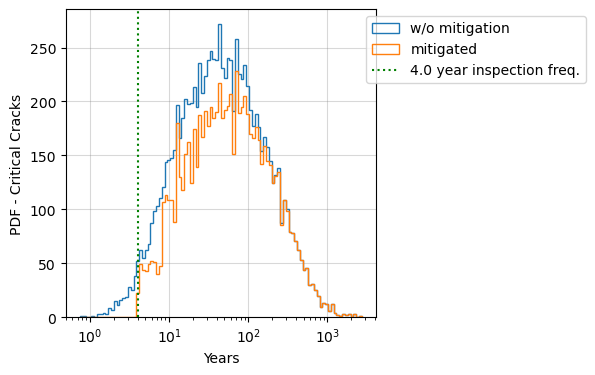

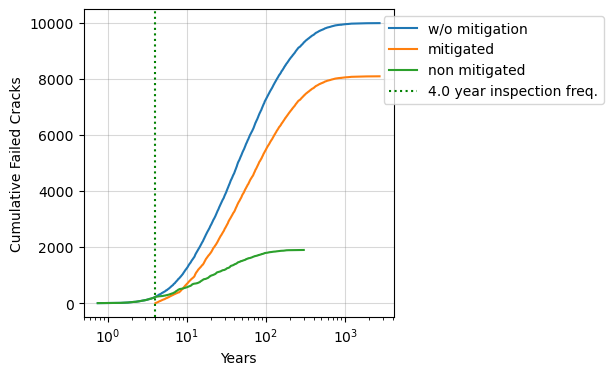

In [ ]:
probability_of_detection = 0.8  # 80%
detection_resolution = 0.3  # able to detect cracks greater than 30% through
inspection_interval = 4  # how many years between inspections
inspection_frequency = 365*inspection_interval  # inspections in terms of cycles
criteria='Cycles to a(crit)'

mitigated = analysis.apply_inspection_mitigation(probability_of_detection,
                                                 detection_resolution,
                                                 inspection_frequency,
                                                 criteria)

In [ ]:
percent_mitigated = sum(mitigated)/sample_size*100
print(f'Percent mitigated through inspection = {percent_mitigated:.1f}%')

Percent mitigated through inspection = 81.0%


In [ ]:
def plot_log_hist(data, label, logbins=None):
    if logbins is None:    
        num_bins = int(np.sqrt(data.size))
        hist, bins = np.histogram(data, bins=num_bins)
        logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
    
    plt.hist(x=data,
            bins=logbins,
            histtype='step',
            density=False,
            label=label)
    return logbins

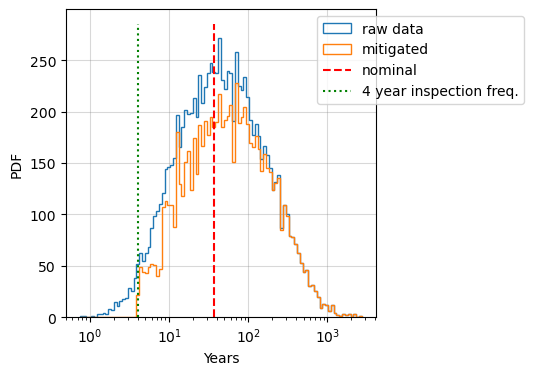

In [ ]:
cycle_life_data = analysis.life_criteria[criteria][0]/365
nominal_life_result = analysis.nominal_life_criteria[criteria][0]/365

mitigated_life_data = cycle_life_data[mitigated]
not_mitigated_life_data = cycle_life_data[np.invert(mitigated)]

plt.figure(figsize=(4, 4))

logbins = plot_log_hist(cycle_life_data, 'raw data')
plot_log_hist(mitigated_life_data, 'mitigated', logbins)

ylims = plt.gca().get_ylim()

plt.plot([nominal_life_result]*2,
         ylims,
         'r--',
         label='nominal')
plt.plot([inspection_interval]*2,
         ylims,
         'g:',
         label=f'{inspection_interval} year inspection freq.')

legend = plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.xlabel('Years')
plt.ylabel('PDF')
plt.xscale('log')
plt.grid(color='gray', alpha=0.3)

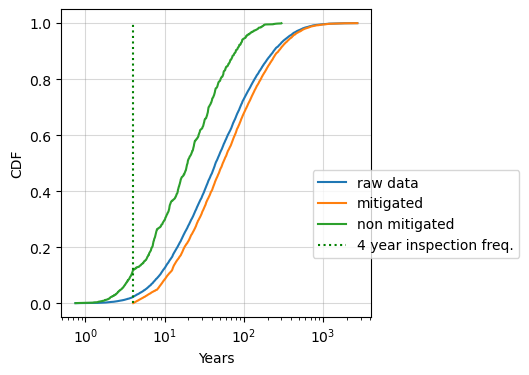

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(np.sort(cycle_life_data),
         np.arange(len(cycle_life_data))/len(cycle_life_data), label='raw data')
plt.plot(np.sort(mitigated_life_data),
         np.arange(len(mitigated_life_data))/len(mitigated_life_data), label='mitigated')
plt.plot(np.sort(not_mitigated_life_data),
         np.arange(len(not_mitigated_life_data))/len(not_mitigated_life_data), label='non mitigated')

plt.plot([inspection_interval]*2,
         [0, 1],
         'g:',
         label=f'{inspection_interval} year inspection freq.')

legend = plt.legend(loc='upper right', bbox_to_anchor=(1.5, 0.5))
plt.xlabel('Years')
plt.ylabel('CDF')
plt.xscale('log')
plt.grid(color='gray', alpha=0.3)

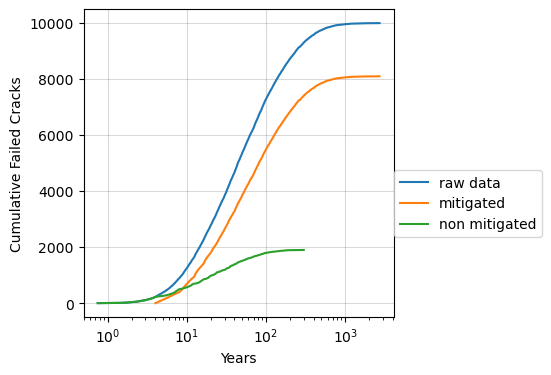

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(np.sort(cycle_life_data),
         np.arange(len(cycle_life_data)), label='raw data')
plt.plot(np.sort(mitigated_life_data),
         np.arange(len(mitigated_life_data)), label='mitigated')
plt.plot(np.sort(not_mitigated_life_data),
         np.arange(len(not_mitigated_life_data)), label='non mitigated')

legend = plt.legend(loc='upper right', bbox_to_anchor=(1.5, 0.5))
plt.xlabel('Years')
plt.ylabel('Cumulative Failed Cracks')
plt.xscale('log')
plt.grid(color='gray', alpha=0.3)